#### CNN 이미지 분류 모델
- 이미지 데이터셋 준비
    * torchvision의 내장 데이터셋 활용 CIFIA10
- 이미지 분류 모델
    * 커스텀 CNN 구현

[1] 모듈 로딩 및 데이터 준비 <hr>

In [2]:
## 모듈로딩
import matplotlib.pyplot as plt
import torch
import torch.nn
from torchvision.datasets import CIFAR10       # torchvision 내장 데이터셋 관련 모듈
from torchvision.transforms import ToTensor    # torchvision 데이터 변환 관련 모듈
from torch.utils.data import DataLoader        # 데이터셋 관련 모듈 로딩

In [3]:
## 데이터로딩
DIR_PATH='../data/'

## Pytorch의 Dataset 형태 로딩
cifarDS=CIFAR10(DIR_PATH,train=True,download=True,transform=ToTensor())

Files already downloaded and verified


In [4]:
# Dataset의 속성 확인
print(f'classses : {cifarDS.classes}')

print(f'cifarDS.data.shape: {cifarDS.data.shape}')

print(f'cifarDS.class_to_idx : {cifarDS.class_to_idx}')

print(f'len(cifarDS.targets) : {len(cifarDS.targets)}')


classses : ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
cifarDS.data.shape: (50000, 32, 32, 3)
cifarDS.class_to_idx : {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
len(cifarDS.targets) : 50000


[2] 데이터 로드 <hr>
* 학습 시 배치크기만큼 데이터와 라벨/타겟을 로딩

In [5]:
BATCH_SIZE = 50

cifar10DL=DataLoader(cifarDS)

tensor([6]) 6
torch.Size([1, 3, 32, 32])


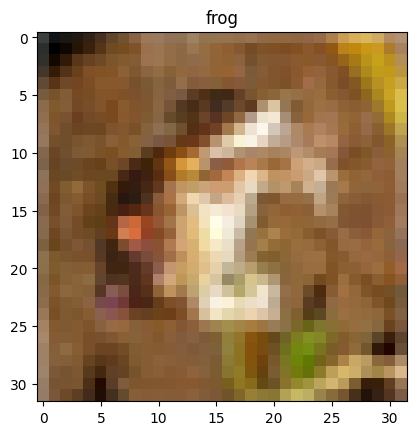

In [6]:
## [테스트] Dataset & DataLoader
for data, target in cifar10DL:
    print(target,target.item())
    print(data.shape)
    data1=data.squeeze()
    plt.imshow(data1.transpose(0,2))
    plt.title(cifarDS.classes[target.item()])
    break
# 데이터 로더로 데이터 땡기니까 shape이 바뀜. 채널이 2번째로 옴.
# 이 데이터를 가지고 그림을 그릴려고 하니 shape이 안 맞아서 shape을 바꿔줘야함.
# 우선 앞에 있는 1을 지우고 3이 채널이니까 맨 뒤로 보내야 함.

[3] 커스텀 모델 설계 및 정의 <hr>
- 모델목적 : 이미지 분류 모델
- 학습방법 : 지도학습 > 분류 > 다중분류(10개)
- 클래스이름 : ImageMCF
- 클래스구조 : 특징추출 부분 => CNN + 학습부분 FC
- 부모클래스 : nn.Module

In [7]:
import torch.nn as nn
import torch.nn.functional as F

In [8]:
class ImageMCF(nn.Module):
    # 모델 구조 설계 즉, 생산자 메서드
    def __init__(self):
        # 부모 생성
        super().__init__()
        # 모델 층 구성
        ## 특징 추출 층
        self.in_layer = nn.Conv2d(3, 10, 3)
        self.in_layer = nn.Conv2d(10, 50, 3)
        self.in_layer = nn.Conv2d(50, 10, 3)
        self.p_layer = nn.MaxPool2d(2,stride=2)
        # 학습 관련 층
        self.hd_layer = nn.Linear(10*15*15,50)
        self.out_layer = nn.Linear(50,10)


    # 전방향/순방향 학습 메서드
    def forward(self,input):
        output=self.in_layer(input)
        print(f'[output 1 ] {output.shape}')

        output = F.relu(output)
        print(f'[output 2 ] {output.shape}')

        output = self.p_layer(output)
        print(f'[output 3 ] {output.shape}')

        # 4D -> 2D (샘플수, 피쳐수)
        output = output.view(output.shape[0],-1)
        print(f'[output 4 ] {output.shape}')

        output = F.relu(self.hd_layer(output))
        print(f'[output 5 ] {output.shape}')

        output = self.out_layer(output)
        print(f'[output 6 ] {output.shape}')

        return output



In [9]:
class ImageMCF2(nn.Module):
    # 모델 구조 설계 즉, 생산자 메서드
    def __init__(self):
        # 부모 생성
        super().__init__()
        # 모델 층 구성
        ## 특징 추출 층
        self.cnn_layer=nn.Sequential(
            nn.Conv2d(3, 10, 3),  # 커널은 초반에 많이 주었다가 갈수록 줄임
            nn.Conv2d(10, 10, 3), #=> 추가하고 싶은면 해당 값에 계산해서 넣으면 됨.
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2)
        )
        self.cnn_layer2=nn.Sequential(
            nn.Conv2d(10, 30, 3),
            nn.ReLU(),   #  나온 결과 값 : [1,30,13,13]
            nn.Conv2d(30, 10, 3),
            nn.ReLU(),
            nn.Conv2d(10, 30, 3),
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2)    #  나온 결과 값 : [1,30,6,6]
        )
        self.cnn_layer3=nn.Sequential(
            nn.Conv2d(30, 10, 3,padding=1),
            nn.ReLU(),  
            nn.Conv2d(10, 30, 3,padding=1),
            nn.ReLU(),
            nn.Conv2d(30, 10, 3,padding=1),
            nn.ReLU(),
            nn.AvgPool2d(2,stride=2)   
        )
        # # 학습 관련 층 
        self.hd_layer = nn.Linear(10*6*6,50)
        self.out_layer = nn.Linear(50,10)


    # 전방향/순방향 학습 메서드
    def forward(self,input):
        output=self.cnn_layer(input)
        print(f'[cnn_layer output ] {output.shape}')

        output=self.cnn_layer2(output)
        print(f'[cnn_layer2 output ] {output.shape}')

        output=self.cnn_layer3(output)
        print(f'[cnn_layer3 output ] {output.shape}')



        # # 4D -> 2D (샘플수, 피쳐수)
        # output = output.view(output.shape[0],-1)
        # print(f'[view output] {output.shape}')

        # output = F.relu(self.hd_layer(output))
        # print(f'[hd_layer output] {output.shape}')

        # output = self.out_layer(output)
        # print(f'[out_layer output] {output.shape}')

        return output



In [10]:
## 모델 인스턴스 생성
m = ImageMCF2()

In [11]:
## 모델 정보 출력 패키지 설치
# %pip install torchinfo

In [12]:
from torchinfo import summary
summary(m)

Layer (type:depth-idx)                   Param #
ImageMCF2                                --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       280
│    └─Conv2d: 2-2                       910
│    └─ReLU: 2-3                         --
│    └─MaxPool2d: 2-4                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-5                       2,730
│    └─ReLU: 2-6                         --
│    └─Conv2d: 2-7                       2,710
│    └─ReLU: 2-8                         --
│    └─Conv2d: 2-9                       2,730
│    └─ReLU: 2-10                        --
│    └─MaxPool2d: 2-11                   --
├─Sequential: 1-3                        --
│    └─Conv2d: 2-12                      2,710
│    └─ReLU: 2-13                        --
│    └─Conv2d: 2-14                      2,730
│    └─ReLU: 2-15                        --
│    └─Conv2d: 2-16                      2,710
│    └─ReLU: 2-17                        --
│    └─

In [13]:
## [테스트] Dataset & Dataloader
for data, target in cifar10DL:
    print(f'[target] => {target}')
    print(data.shape)
    # 학습 
    pre = m(data)
    print(f'pre => {pre.argmax(dim=1)}')
    break

[target] => tensor([6])
torch.Size([1, 3, 32, 32])
[cnn_layer output ] torch.Size([1, 10, 14, 14])
[cnn_layer2 output ] torch.Size([1, 30, 4, 4])
[cnn_layer3 output ] torch.Size([1, 10, 2, 2])
pre => tensor([[[5, 2],
         [2, 2]]])


In [14]:
# 모델 파라미터 확인
for name, param in m.named_parameters():
    print(f'>>[{name}]-----------\n{param.shape}')

>>[cnn_layer.0.weight]-----------
torch.Size([10, 3, 3, 3])
>>[cnn_layer.0.bias]-----------
torch.Size([10])
>>[cnn_layer.1.weight]-----------
torch.Size([10, 10, 3, 3])
>>[cnn_layer.1.bias]-----------
torch.Size([10])
>>[cnn_layer2.0.weight]-----------
torch.Size([30, 10, 3, 3])
>>[cnn_layer2.0.bias]-----------
torch.Size([30])
>>[cnn_layer2.2.weight]-----------
torch.Size([10, 30, 3, 3])
>>[cnn_layer2.2.bias]-----------
torch.Size([10])
>>[cnn_layer2.4.weight]-----------
torch.Size([30, 10, 3, 3])
>>[cnn_layer2.4.bias]-----------
torch.Size([30])
>>[cnn_layer3.0.weight]-----------
torch.Size([10, 30, 3, 3])
>>[cnn_layer3.0.bias]-----------
torch.Size([10])
>>[cnn_layer3.2.weight]-----------
torch.Size([30, 10, 3, 3])
>>[cnn_layer3.2.bias]-----------
torch.Size([30])
>>[cnn_layer3.4.weight]-----------
torch.Size([10, 30, 3, 3])
>>[cnn_layer3.4.bias]-----------
torch.Size([10])
>>[hd_layer.weight]-----------
torch.Size([50, 360])
>>[hd_layer.bias]-----------
torch.Size([50])
>>[out_lay